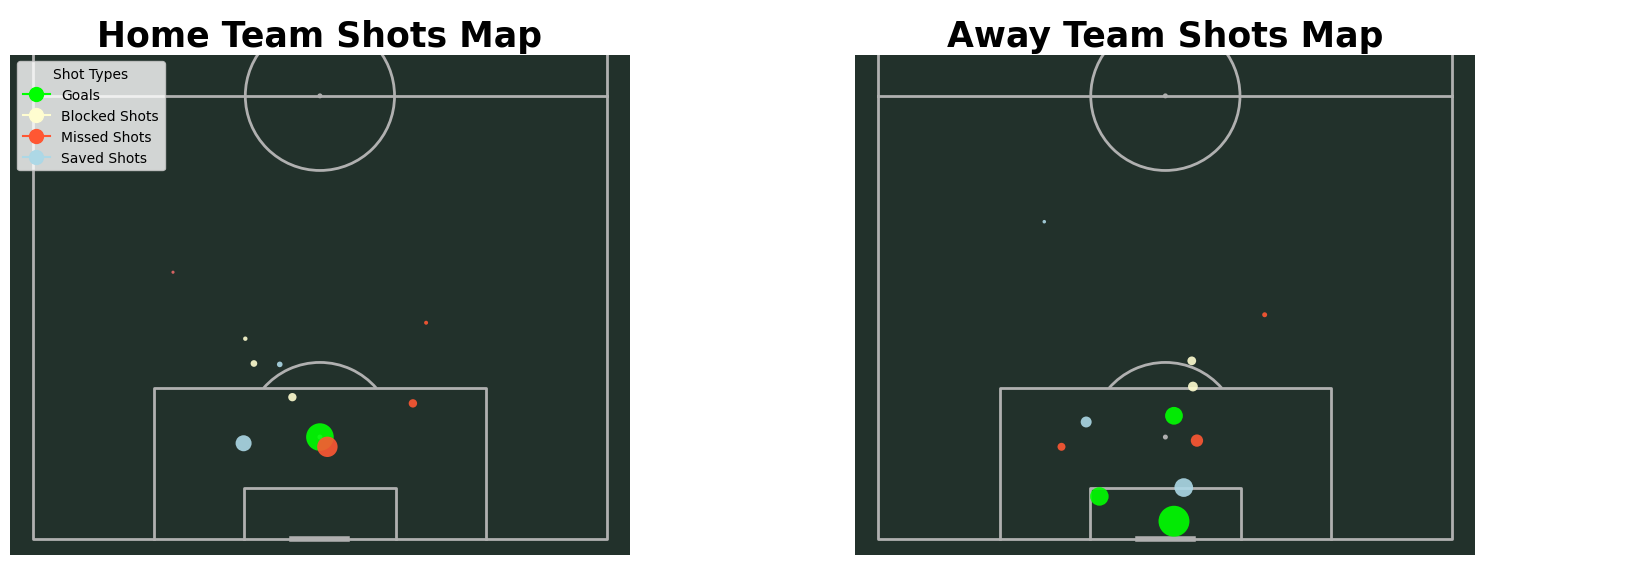

In [360]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch

def plot_shotmap(match_id):
    # Fetch the shotmap data
    response = requests.get(f'https://sofascore.com/api/v1/event/{match_id}/shotmap')
    shots = response.json()

    # Normalize the shotmap data into a DataFrame
    df = pd.json_normalize(shots['shotmap'])
    
    df = df[df['situation'] != 'shootout']

    # Define the selected columns
    selected_columns = ['isHome', 'shotType', 'situation', 'bodyPart', 'goalMouthLocation',
                        'xg', 'id', 'time', 'addedTime', 'timeSeconds', 'reversedPeriodTime',
                        'reversedPeriodTimeSeconds', 'incidentType', 'player.name', 'player.position', 
                        'player.jerseyNumber', 'player.id', 'playerCoordinates.x', 'playerCoordinates.y', 
                        'playerCoordinates.z', 'goalMouthCoordinates.x', 'goalMouthCoordinates.y', 
                        'goalMouthCoordinates.z', 'blockCoordinates.x', 'blockCoordinates.y', 'blockCoordinates.z', 
                        'draw.start.x', 'draw.start.y', 'draw.block.x', 'draw.block.y', 'draw.end.x', 'draw.end.y', 
                        'draw.goal.x', 'draw.goal.y', 'goalType', 'xgot']

    # Filter the DataFrame to include only the selected columns
    result_df = df[selected_columns].copy()

    # Filter result_df where 'isHome' column is true
    result_df_home = result_df[result_df['isHome']].copy()
    # Filter result_df where 'isHome' column is false
    result_df_away = result_df[~result_df['isHome']].copy()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 6.5))

    for ax, df, title in zip(axes, [result_df_home, result_df_away], ['Home', 'Away']):
        # Create a VerticalPitch with half=True need to pad since the coords are for the bottom half.
        pitch = VerticalPitch(half=True, pad_top=-70, pad_bottom=80, pitch_color='#22312b', pitch_type = 'opta')  # Set background color to #22312b

        # Get the figure and axis objects from the pitch
        pitch.draw(ax=ax)

        df['edge_color'] = '#ea6969'  # Default edge color
        df['face_color'] = None  # Blank face color

        # Change the edge color based on shot type
        df.loc[df['shotType'] == 'goal', 'edge_color'] = '#00FF00'  # Goal
        df.loc[df['shotType'] == 'block', 'edge_color'] = '#fffdd0'  # Block
        df.loc[df['shotType'] == 'miss', 'edge_color'] = '#FF5733'  # Miss
        df.loc[df['shotType'] == 'save', 'edge_color'] = '#ADD8E6'  # Save

        # Draw the scatter plot on the main pitch with solid circles and respective edge colors
        scatter = ax.scatter(df['draw.start.x'], df['draw.start.y'], facecolors=df['edge_color'],
                             edgecolors='none', marker='o', s=df['xg']*500, linewidth=1, alpha=.9, label='Shots Missed')

        # Customize the scatter plot as needed
        ax.set_title(f'{title} Team Shots Map', c='black', fontsize=25, weight='bold')

    # Add legend with handles using the same edge color and face color as shots
    legend_labels = {'goal': 'Goals', 'block': 'Blocked Shots', 'miss': 'Missed Shots', 'save': 'Saved Shots'}
    handles = [
        plt.Line2D([0], [0], marker='o', color=color, markerfacecolor=color, markeredgecolor=color, markersize=10, label=label)
        for color, label in zip(['#00FF00', '#fffdd0', '#FF5733', '#ADD8E6'], legend_labels.values())
    ]
    axes[0].legend(handles=handles, title='Shot Types', loc='upper left')

    # Add annotation in the top right corner
    plt.annotate('Circle Sizes Represent xG', xy=(0.95, 0.95), xycoords='figure fraction', ha='right', va='top',
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='white', alpha=0.7), fontsize=14)

    plt.show()

# Call the function
plot_shotmap(11911648)


In [2]:
import json
import httpx
import pandas as pd
import asyncio
import nest_asyncio
import numpy as np
from PIL import Image
from io import BytesIO
import janitor


In [350]:
class Spider:
    def __init__(self):
        self.comments =  "https://www.sofascore.com/api/v1/event/12173502/comments"
        self.shotmap =  "https://www.sofascore.com/api/v1/event/12173502/shotmap"
        self.event = "https://www.sofascore.com/api/v1/event/12173502"
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36',
            'Accept': 'application/json, text/plain, */*',
            'Accept-Language': 'en-US,en;q=0.5',
            'Connection': 'keep-alive',
            'Referer': 'https://www.sofascore.com/',
            'Origin': 'https://www.sofascore.com'
        }
    
    async def get_comments(self):
        async with httpx.AsyncClient(headers=self.headers) as client:
            response = await client.get(self.comments)  
            df = pd.json_normalize(response.json().get('comments'))
            df['game_id'] = 12173502 # hard keyed for now
            return df
    
    async def get_shotmap(self):
        async with httpx.AsyncClient(headers=self.headers) as client:
            response = await client.get(self.shotmap) 
            df = pd.json_normalize(response.json().get('shotmap'))
            df['game_id'] = 12173502
            return df
    
    async def get_event(self):
        async with httpx.AsyncClient(headers=self.headers) as client:
            response = await client.get(self.event)  
            return pd.json_normalize(response.json().get('event'))
            

In [351]:
nest_asyncio.apply()

spider = Spider()
comments_data = await spider.get_comments()
shotmap_data = await spider.get_shotmap()
event_data = await spider.get_event()
    

In [53]:
comments_data.at[0, 'time'] = comments_data.at[1, 'time']

In [54]:
shots = ['shotOffTarget', 'shotBlocked', 'scoreChange', 'post', 'penaltyScored', 'shotSaved']


In [55]:
shotmap_data['time_min'] = (shotmap_data['timeSeconds'] / 60).apply(np.floor).astype(int)
shotmap_data['player.id'] = shotmap_data['player.id'].astype(float)

In [56]:
shotmap_data = shotmap_data.sort_values(by='time_min')

In [57]:
cols = ['shotType', 'situation', 'bodyPart', 'goalMouthLocation', 'xg','addedTime', 'timeSeconds', 'reversedPeriodTime', 
       'reversedPeriodTimeSeconds', 'incidentType', 'player.id','playerCoordinates.x', 'playerCoordinates.y', 'playerCoordinates.z',
       'goalMouthCoordinates.x', 'goalMouthCoordinates.y',
       'goalMouthCoordinates.z', 'draw.start.x', 'draw.start.y', 'draw.end.x',
       'draw.end.y', 'draw.goal.x', 'draw.goal.y', 'xgot',
       'blockCoordinates.x', 'blockCoordinates.y', 'blockCoordinates.z',
       'draw.block.x', 'draw.block.y', 'goalType', 'time_min', 'game_id']

shotmap_data = shotmap_data[cols]

# missed player 142622.0

In [59]:
comments_data = comments_data.sort_values(by = 'time')

In [217]:
# Some times may be off by 1 so this merge takes care of this by allotting an error of 1
# note: For larger scale I must specify the game ID for the merge
# Yuck 2 merges for missing data

# Missing data_merge
merged_df = pd.merge_asof(
    comments_data, 
    shotmap_data, 
    left_on='time', 
    right_on = 'time_min', 
    by=['game_id','player.id'], 
    tolerance=1
)

missing_data = pd.merge(
    comments_data,
    shotmap_data,
    how='right',
    left_on=['time', 'game_id'],
    right_on=['time_min', 'game_id'],
    indicator=True,
    suffixes=('_orig', '')
).query('_merge == "right_only"').drop(columns=['_merge'])



merged_df = pd.concat([merged_df, missing_data], ignore_index=True)
merged_df = merged_df.drop(columns=merged_df.filter(regex='_orig$').columns)
merged_df['time'] = merged_df['time'].fillna(merged_df['time_min'])

merged_df = merged_df.sort_values(by='time')




In [221]:
event_data = event_data.groupby('id').agg(
    home_team = ('homeTeam.name', 'first'),
    away_team = ('awayTeam.name', 'first'),
    home_team_id = ('homeTeam.id', 'first'),
    away_team_id = ('awayTeam.id', 'first')
)

merged_df = merged_df.merge(event_data, left_on = 'game_id', right_on = 'id', how = 'left')

In [222]:
merged_df['posteam'] = np.where(merged_df['isHome'] == True, merged_df['home_team'], merged_df['away_team']) # fix this
merged_df['defteam'] = np.where(merged_df['isHome'] == False, merged_df['home_team'], merged_df['away_team']) # fix this


In [223]:
merged_df = janitor.clean_names(merged_df)


merged_df.drop(['time_min', 'ishome', 'player_firstname', 'player_lastname', 'playerin_firstname', 'playerin_lastname', 'assist1_firstname', 'assist1_lastname'], inplace = True, axis =1)



In [224]:
def map_scores(df):
    df['home_score'] = 0
    df['away_score'] = 0
    
    for game_id, game_df in df.groupby('game_id'):
        home_score = 0
        away_score = 0
        for index, row in game_df.iterrows():
            if row['type'] in ['scoreChange', 'penaltyScored']:
                if row['posteam'] == row['home_team']:
                    home_score += 1
                else:
                    away_score += 1
            df.at[index, 'home_score'] = home_score
            df.at[index, 'away_score'] = away_score
    
    return df


In [225]:
merged_df = map_scores(merged_df)

In [326]:
merged_df

,text,type,id,time,periodname,player_name,player_slug,player_shortname,player_position,player_jerseynumber,...,draw_block_y,goaltype,home_team,away_team,home_team_id,away_team_id,posteam,defteam,home_score,away_score
0,First Half begins.,matchStarted,23550683.0,0.0,1ST,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Manchester City,Real Madrid,17,2829,Real Madrid,Real Madrid,0,0
1,Josko Gvardiol (Manchester City) wins a free k...,freeKickWon,23550940.0,5.0,1ST,Joško Gvardiol,josko-gvardiol,J. Gvardiol,D,24,...,NaN,NaN,Manchester City,Real Madrid,17,2829,Manchester City,Real Madrid,0,0
2,Foul by Federico Valverde (Real Madrid).,freeKickLost,23550941.0,5.0,1ST,Federico Valverde,federico-valverde,F. Valverde,M,15,...,NaN,NaN,Manchester City,Real Madrid,17,2829,Real Madrid,Manchester City,0,0
3,Attempt saved. Eduardo Camavinga (Real Madrid)...,shotSaved,23550982.0,10.0,1ST,Eduardo Camavinga,camavinga-eduardo,E. Camavinga,M,12,...,2.2,NaN,Manchester City,Real Madrid,17,2829,Real Madrid,Manchester City,0,0
4,Attempt saved. Rodrygo (Real Madrid) right foo...,shotSaved,23550998.0,11.0,1ST,Rodrygo,rodrygo,Rodrygo,F,11,...,NaN,regular,Manchester City,Real Madrid,17,2829,Real Madrid,Manchester City,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,"Goal! Manchester City 1(2), Real Madrid 1(2)....",penaltyScored,23552343.0,125.0,PEN,Phil Foden,phil-foden,P. Foden,M,47,...,NaN,penalty,Manchester City,Real Madrid,17,2829,Manchester City,Real Madrid,3,3
150,"Goal! Manchester City 1(2), Real Madrid 1(3)....",penaltyScored,23552347.0,125.0,PEN,Nacho Fernández,nacho-fernandez,N. Fernández,D,6,...,NaN,penalty,Manchester City,Real Madrid,17,2829,Real Madrid,Manchester City,3,4
151,"Goal! Manchester City 1(3), Real Madrid 1(3)....",penaltyScored,23552348.0,126.0,PEN,Ederson,ederson,Ederson,G,31,...,NaN,penalty,Manchester City,Real Madrid,17,2829,Manchester City,Real Madrid,4,4
152,"Goal! Manchester City 1(3), Real Madrid 1(4)....",penaltyScored,23552350.0,127.0,PEN,Antonio Rüdiger,antonio-rudiger,A. Rüdiger,D,22,...,NaN,penalty,Manchester City,Real Madrid,17,2829,Real Madrid,Manchester City,4,5


In [236]:
 with httpx.Client() as client:
    response = client.get('https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/standings/total').json()

In [270]:
def league_standings(home = False, away = False):
    url = 'https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/standings/total'
    if home:
        url = 'https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/standings/home'
    if away:
        url = 'https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/standings/away'
        
    with httpx.Client() as client:
        response = client.get(url)  
    return pd.json_normalize(response.json().get('standings')[0].get('rows'))
    
standings = league_standings()
    
    

In [311]:
url = 'https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/statistics?limit=100&order=-rating&accumulation=total&group=attack'
with httpx.Client() as client:
    response = client.get(url).json().get('results')
        
        





In [312]:
pd.json_normalize(response)

,goals,expectedGoals,bigChancesMissed,successfulDribbles,totalShots,goalConversionPercentage,rating,player.name,player.slug,player.userCount,...,player.fieldTranslations.shortNameTranslation.ar,team.name,team.slug,team.shortName,team.id,team.teamColors.primary,team.teamColors.secondary,team.teamColors.text,team.fieldTranslations.nameTranslation.ar,team.fieldTranslations.nameTranslation.ru
0,8,4.07,2,42,62,12.90,8.01,Rodri,rodri,40580,...,رودري,Manchester City,manchester-city,Manchester City,17,#52b030,#52b030,#ffffff,مانشستر سيتي,Манчестер Сити
1,0,NaN,0,0,0,0.00,8.00,Arijanet Murić,arijanet-muric,1339,...,ا. موريك,Burnley,burnley,Burnley,6,#52b030,#52b030,#ffffff,بيرنلي,Бернли
2,4,2.41,1,10,44,9.09,7.93,Kevin De Bruyne,kevin-de-bruyne,232765,...,ك. د. بروين,Manchester City,manchester-city,Manchester City,17,#52b030,#52b030,#ffffff,مانشستر سيتي,Манчестер Сити
3,19,10.34,7,47,105,18.10,7.79,Phil Foden,phil-foden,104780,...,ف. فودن,Manchester City,manchester-city,Manchester City,17,#52b030,#52b030,#ffffff,مانشستر سيتي,Манчестер Сити
4,10,10.00,7,19,95,10.53,7.75,Bruno Fernandes,bruno-fernandes,115073,...,ب. فيرنانديس,Manchester United,manchester-united,Manchester United,35,#52b030,#52b030,#ffffff,مانتشستر يونايتد,Манчестер Юнайтед
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0.16,0,3,2,0.00,7.10,Aleksandar Mitrović,aleksandar-mitrovic,23087,...,ا. ميتروفيتش,Fulham,fulham,Fulham,43,#52b030,#52b030,#ffffff,فولهام,Фулхэм
96,0,0.00,0,0,0,0.00,7.10,Robin Olsen,robin-olsen,1153,...,ر. اولسن,Aston Villa,aston-villa,Aston Villa,40,#52b030,#52b030,#ffffff,أستون فيلا,Астон Вилла
97,0,0.00,0,0,0,0.00,7.10,Bernd Leno,bernd-leno,3557,...,ب. لينو,Fulham,fulham,Fulham,43,#52b030,#52b030,#ffffff,فولهام,Фулхэм
98,1,2.71,1,19,41,2.44,7.09,James Garner,james-garner,2609,...,ج. جارنر,Everton,everton,Everton,48,#52b030,#52b030,#ffffff,إيفرتون,Эвертон


In [269]:
pd.json_normalize(response.get('standings')[0].get('rows')).drop(['descriptions', 'position', 'id', 'team.national','team.disabled', 'team.type', 'team.sport.name', 'team.sport.slug', 'team.sport.id'], axis = 1)



,matches,wins,scoresFor,scoresAgainst,losses,draws,points,team.name,team.slug,team.shortName,...,team.userCount,team.nameCode,team.id,team.teamColors.primary,team.teamColors.secondary,team.teamColors.text,team.fieldTranslations.nameTranslation.ar,team.fieldTranslations.nameTranslation.ru,promotion.text,promotion.id
0,38,28,96,34,3,7,91,Manchester City,manchester-city,Man City,...,2211706,MCI,17,#66ccff,#ffffff,#ffffff,مانشستر سيتي,Манчестер Сити,Champions League,804.0
1,38,28,91,29,5,5,89,Arsenal,arsenal,Arsenal,...,1679703,ARS,42,#cc0000,#ffffff,#ffffff,أرسنال,Арсенал,Champions League,804.0
2,38,24,86,41,4,10,82,Liverpool,liverpool,Liverpool,...,1911481,LIV,44,#cc0000,#ffffff,#ffffff,ليفربول,Ливерпуль,Champions League,804.0
3,38,20,76,61,10,8,68,Aston Villa,aston-villa,Aston Villa,...,520638,AVL,40,#670e36,#94bee5,#94bee5,أستون فيلا,Астон Вилла,Champions League,804.0
4,38,20,74,61,12,6,66,Tottenham Hotspur,tottenham-hotspur,Tottenham,...,961118,TOT,33,#ffffff,#000066,#000066,توتنهام هوتسبير,Тоттенхэм Хотспур,UEFA Europa League,808.0
5,38,18,77,63,11,9,63,Chelsea,chelsea,Chelsea,...,1498564,CHE,38,#0310a7,#ffffff,#ffffff,تشيلسي,Челси,UEFA Conference League,1443.0
6,38,18,85,62,14,6,60,Newcastle United,newcastle-united,Newcastle,...,637059,NEW,39,#000000,#ffffff,#ffffff,نيوكاسل يونايتد,Ньюкасл Юнайтед,NaN,NaN
7,38,18,57,58,14,6,60,Manchester United,manchester-united,Man Utd,...,1921393,MUN,35,#ff0000,#373737,#373737,مانتشستر يونايتد,Манчестер Юнайтед,NaN,NaN
8,38,14,60,74,14,10,52,West Ham United,west-ham-united,West Ham,...,476903,WHU,37,#66192c,#59b3e4,#59b3e4,وست هام يونايتد,Вест Хэм Юнайтед,NaN,NaN
9,38,13,57,58,15,10,49,Crystal Palace,crystal-palace,Crystal Palace,...,254003,CRY,7,#0033ff,#b90d2b,#b90d2b,كريستال بالاس,Кристал Пэлас,NaN,NaN


In [80]:
#list(event_data.columns) # may use hasXg, 'hasXg','hasEventPlayerStatistics','hasEventPlayerHeatMap', as try catch or something



In [371]:
url = 'https://www.sofascore.com/api/v1/player/12994/attribute-overviews'
with httpx.Client() as client:
    response = client.get(url).json().get('averageAttributeOverviews')


In [372]:
pd.json_normalize(response)

,attacking,technical,tactical,defending,creativity,position,yearShift,id
0,66,53,46,30,51,F,0,19812


In [4]:
url = 'https://www.sofascore.com/api/v1/player/934386/image'

headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.5',
    'Connection': 'keep-alive',
    'Referer': 'https://www.sofascore.com/',
    'Origin': 'https://www.sofascore.com'
}

with httpx.Client(headers=headers) as client:
    response = client.get(url)
    i = Image.open(BytesIO(response.content))



If it's a large request, use tqdm to provide user with download time:

```
import tempfile

import httpx
from tqdm import tqdm

with tempfile.NamedTemporaryFile() as download_file:
    url = "https://speed.hetzner.de/100MB.bin"
    with httpx.stream("GET", url) as response:
        total = int(response.headers["Content-Length"])

        with tqdm(total=total, unit_scale=True, unit_divisor=1024, unit="B") as progress:
            num_bytes_downloaded = response.num_bytes_downloaded
            for chunk in response.iter_bytes():
                download_file.write(chunk)
                progress.update(response.num_bytes_downloaded - num_bytes_downloaded)
                num_bytes_downloaded = response.num_bytes_downloaded
```

Note: Don't literally code this, use it as a reference. It's just opening a temp file then running a request to website


Making multiple requests at once:

```
import asyncio
import httpx

async def do_tasks():
    async with httpx.AsyncClient() as client:
        tasks = [client.get(f"http://my-api/{url_param}") for url_param in parameters]
        result = await asyncio.gather(*tasks)

```

In [11]:
game.columns

Index(['text', 'type', 'id', 'time', 'periodName', 'isHome', 'player.name',
       'player.slug', 'player.shortName', 'player.position',
       'player.jerseyNumber', 'player.userCount', 'player.id',
       'player.fieldTranslations.nameTranslation.ar',
       'player.fieldTranslations.shortNameTranslation.ar', 'player.firstName',
       'player.lastName', 'assist1.name', 'assist1.slug', 'assist1.shortName',
       'assist1.position', 'assist1.jerseyNumber', 'assist1.userCount',
       'assist1.id', 'assist1.fieldTranslations.nameTranslation.ar',
       'assist1.fieldTranslations.shortNameTranslation.ar', 'playerIn.name',
       'playerIn.slug', 'playerIn.shortName', 'playerIn.position',
       'playerIn.jerseyNumber', 'playerIn.userCount', 'playerIn.id',
       'playerOut.name', 'playerOut.slug', 'playerOut.shortName',
       'playerOut.position', 'playerOut.jerseyNumber', 'playerOut.userCount',
       'playerOut.id', 'playerOut.fieldTranslations.nameTranslation.ar',
       'playerOut

In [53]:
stats = pd.json_normalize(df.explode('statisticsItems')['statisticsItems'])

In [80]:
stats.head()

,name,home,away,compareCode,statisticsType,valueType,homeValue,awayValue,renderType,key,homeTotal,awayTotal
0,Ball possession,74%,26%,1,positive,event,74.00,26.00,2,ballPossession,NaN,NaN
1,Expected goals,4.32,0.51,1,positive,event,4.32,0.51,1,expectedGoals,NaN,NaN
2,Big chances,5,2,1,positive,event,5.00,2.00,1,bigChanceCreated,NaN,NaN
3,Total shots,37,4,1,positive,event,37.00,4.00,1,totalShotsOnGoal,NaN,NaN
4,Goalkeeper saves,1,9,2,positive,event,1.00,9.00,1,goalkeeperSaves,NaN,NaN


In [ ]:
stats.set_index("name", inplace=True)



In [90]:
# Transpose the DataFrame
stats.T.iloc[:2, :].reset_index()

name,index,Ball possession,Expected goals,Big chances,Total shots,Goalkeeper saves,Corner kicks,Fouls,Passes,Tackles,...,Aerial duels,Dribbles,Tackles won,Total tackles,Interceptions,Recoveries,Clearances,Total saves,Goals prevented,Goal kicks
0,home,74%,4.32,5,37,1,12,7,763,20,...,9/23 (39%),10/18 (56%),65%,20,5,52,3,1,0.23,1
1,away,26%,0.51,2,4,9,1,6,276,13,...,14/23 (61%),7/11 (64%),54%,13,8,44,28,9,-1.18,16


In [78]:
stats = [
    'goals', 'successfulDribbles', 'tackles', 'assists', 'accuratePassesPercentage', 'rating',
    'successfulDribblesPercentage', 'blockedShots', 'penaltyWon', 'goalsFromOutsideTheBox', 
    'hitWoodwork', 'expectedGoals', 'totalShots', 'goalConversionPercentage', 
    'headedGoals', 'offsides', 'bigChancesMissed', 'shotsOnTarget', 'penaltiesTaken', 
    'leftFootGoals', 'shotsOffTarget', 'penaltyGoals', 'goalsFromInsideTheBox', 
    'rightFootGoals', 'ownGoals', 'dribbledPast', 'bigChancesCreated', 'totalPasses', 'accurateFinalThirdPasses',
    'keyPasses', 'accurateLongBallsPercentage', 'accuratePasses', 
    'accurateOwnHalfPasses', 'accurateCrosses',  'inaccuratePasses', 'accurateOppositionHalfPasses',
    'accurateCrossesPercentage', 'yellowCards', 'redCards', 'aerialDuelsWon', 'minutesPlayed', 'possessionLost',
    'aerialDuelsWonPercentage', 'wasFouled', 'appearances', 'groundDuelsWon', 'totalDuelsWon', 'fouls', 
    'groundDuelsWonPercentage', 'totalDuelsWonPercentage', 'dispossessed', 'saves', 'punches',
    'crossesNotClaimed', 'runsOut', 'goalsConcededInsideTheBox',
    'successfulRunsOut', 'goalsConcededOutsideTheBox', 'highClaims', 'shotFromSetPiece', 'freeKickGoal', 
    'penaltyConversion', 'setPieceConversion', 'errorLeadToGoal', 'cleanSheet', 'clearances', 'accurateLongBalls',
    'passToAssist', 'matchesStarted', 'savedShotsFromInsideTheBox',
    'savedShotsFromOutsideTheBox', 'penaltySave', 'penaltyFaced', 'penaltyConceded', 
    'interceptions', 'errorLeadToShot'
] 

# Convert the list of stats into a comma-separated string
fields = ','.join(stats)

# # Base URL
# base_url = 'https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/statistics'

# # Construct the full URL with parameters
# url = f'{base_url}?limit=100&offset=0&order=-rating&accumulation=total&fields={fields}&filters=position.in.G~D~M~F'

# # Send the request and get the response
# with httpx.Client() as client:
#     response = client.get(url)
#     results = response.json().get('results')

In [102]:
def get_season_stats(positions:list, fields, accumulation = 'total', preferred_foot=None, home_away = None):
    base_url = 'https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/statistics'
    df = pd.DataFrame()
    for pos in positions:
        for offset in range(0, 400, 100):
            url = f'{base_url}?limit=100&offset={offset}&order=-rating&accumulation={accumulation}&fields={fields}&filters=position.in.{pos}&preferredFoot.EQ.{preferred_foot}&type.EQ.{home_away}'
            print(url)
            with httpx.Client() as client:
                response = client.get(url)
                results = response.json().get('results')

                sub_df = pd.json_normalize(results)
                sub_df['position'] = pos

                df = pd.concat([df, sub_df])
    return df
            
            
    

    

In [103]:
data = get_season_stats(['G', 'F', 'M', 'D'], fields)

https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/statistics?limit=100&offset=0&order=-rating&accumulation=total&fields=goals,successfulDribbles,tackles,assists,accuratePassesPercentage,rating,successfulDribblesPercentage,blockedShots,penaltyWon,goalsFromOutsideTheBox,hitWoodwork,expectedGoals,totalShots,goalConversionPercentage,headedGoals,offsides,bigChancesMissed,shotsOnTarget,penaltiesTaken,leftFootGoals,shotsOffTarget,penaltyGoals,goalsFromInsideTheBox,rightFootGoals,ownGoals,dribbledPast,bigChancesCreated,totalPasses,accurateFinalThirdPasses,keyPasses,accurateLongBallsPercentage,accuratePasses,accurateOwnHalfPasses,accurateCrosses,inaccuratePasses,accurateOppositionHalfPasses,accurateCrossesPercentage,yellowCards,redCards,aerialDuelsWon,minutesPlayed,possessionLost,aerialDuelsWonPercentage,wasFouled,appearances,groundDuelsWon,totalDuelsWon,fouls,groundDuelsWonPercentage,totalDuelsWonPercentage,dispossessed,saves,punches,crossesNotClaimed,runsOut,goalsConcededInsi

https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/statistics?limit=100&offset=200&order=-rating&accumulation=total&fields=goals,successfulDribbles,tackles,assists,accuratePassesPercentage,rating,successfulDribblesPercentage,blockedShots,penaltyWon,goalsFromOutsideTheBox,hitWoodwork,expectedGoals,totalShots,goalConversionPercentage,headedGoals,offsides,bigChancesMissed,shotsOnTarget,penaltiesTaken,leftFootGoals,shotsOffTarget,penaltyGoals,goalsFromInsideTheBox,rightFootGoals,ownGoals,dribbledPast,bigChancesCreated,totalPasses,accurateFinalThirdPasses,keyPasses,accurateLongBallsPercentage,accuratePasses,accurateOwnHalfPasses,accurateCrosses,inaccuratePasses,accurateOppositionHalfPasses,accurateCrossesPercentage,yellowCards,redCards,aerialDuelsWon,minutesPlayed,possessionLost,aerialDuelsWonPercentage,wasFouled,appearances,groundDuelsWon,totalDuelsWon,fouls,groundDuelsWonPercentage,totalDuelsWonPercentage,dispossessed,saves,punches,crossesNotClaimed,runsOut,goalsConcededIn

https://www.sofascore.com/api/v1/unique-tournament/17/season/52186/statistics?limit=100&offset=0&order=-rating&accumulation=total&fields=goals,successfulDribbles,tackles,assists,accuratePassesPercentage,rating,successfulDribblesPercentage,blockedShots,penaltyWon,goalsFromOutsideTheBox,hitWoodwork,expectedGoals,totalShots,goalConversionPercentage,headedGoals,offsides,bigChancesMissed,shotsOnTarget,penaltiesTaken,leftFootGoals,shotsOffTarget,penaltyGoals,goalsFromInsideTheBox,rightFootGoals,ownGoals,dribbledPast,bigChancesCreated,totalPasses,accurateFinalThirdPasses,keyPasses,accurateLongBallsPercentage,accuratePasses,accurateOwnHalfPasses,accurateCrosses,inaccuratePasses,accurateOppositionHalfPasses,accurateCrossesPercentage,yellowCards,redCards,aerialDuelsWon,minutesPlayed,possessionLost,aerialDuelsWonPercentage,wasFouled,appearances,groundDuelsWon,totalDuelsWon,fouls,groundDuelsWonPercentage,totalDuelsWonPercentage,dispossessed,saves,punches,crossesNotClaimed,runsOut,goalsConcededInsi

In [19]:
import json

from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService

from webdriver_manager.chrome import ChromeDriverManager

In [20]:
options = webdriver.ChromeOptions()
options.set_capability(
    "goog:loggingPrefs", {"performance": "ALL", "browser": "ALL"}
)


driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)
driver.set_page_load_timeout(10)

try:
    driver.get("https://www.sofascore.com/luton-town-fulham/Tsxb#id:11352568")
except:
    pass


driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

In [21]:
logs_raw = driver.get_log("performance")
logs = [json.loads(lr["message"])["message"] for lr in logs_raw]

In [ ]:
for x in logs:
    path = x['params'].get('headers', {}).get(':path', '') # Extract the ':path' value from the headers, defaulting to an empty string if not found
    if '/api/' in path:
        print(path)

In [29]:
import requests

response = requests.get('https://www.sofascore.com/api/v1/event/11352568/shotmap').json()

